# Anomalies in RU2020 vote

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
df = pd.read_csv('cleaned.csv')
df['turnout'] = df['given']/np.maximum(1, df['nominal'])
df['support'] = df['yes']/np.maximum(1, df['given'])

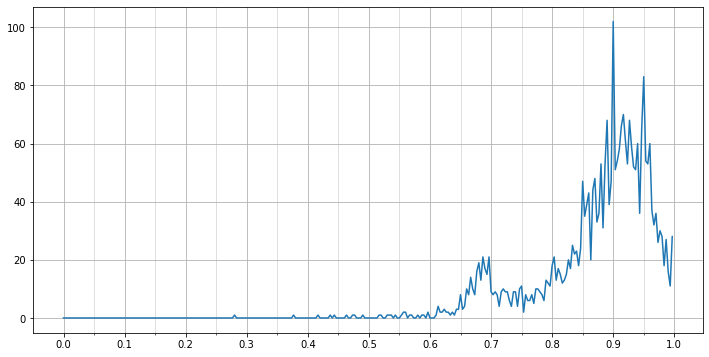

In [88]:
# One region of interest

df1 = df[:][df.region == 'Краснодарский']
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
x = np.histogram(df1['turnout'].values, bins=300, range=(0,1))
plt.plot(x[1][:-1], x[0])
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_xticks(np.arange(0,1,0.05), minor=True)
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', alpha=1)

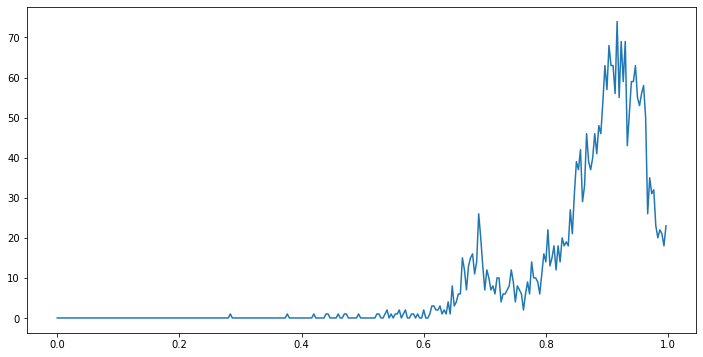

In [235]:
# Noisificator from a diff notebook, not yet functional

def noisify(df1):
    nexp = 1
    sigma = 0.005 # Noisification coefficient
    temp = df1.copy()
    temp['given'] = np.round(temp['nominal']*(temp['turnout']+np.random.normal(size=len(temp))*sigma))
    temp['given'] = np.maximum(0, np.minimum(temp['nominal'], temp['given'])).astype(int)
    temp['yes'] = np.round(temp['given']*(temp['turnout']+np.random.normal(size=len(temp))*sigma))
    temp['yes'] = np.maximum(0, np.minimum(temp['given'], temp['yes'])).astype(int)
    temp['turnout'] = temp.given / temp.nominal
    temp['support'] = temp.yes / temp.given
    return temp

plt.figure(figsize=(12, 6))
x = np.histogram(noisify(df1)['turnout'].values, bins=300, range=(0,1))
plt.plot(x[1][:-1], x[0]);

In [253]:
def measure_comb(vals):
    """For values between 0 and 1, measure how comb-like they are."""
    x = np.histogram(vals, bins=np.arange(0, 1.005, 0.005)-0.002, range=(0,1))
    # This small offset of 0.002 to account for rounding errors around 1%-level values
    return np.sum(x[0][np.arange(50,100)*2])/np.sum(x[0][np.arange(50,100)*2 + 1])
    
print(measure_comb(df1.turnout))

print(np.mean([measure_comb(noisify(df1).turnout) for i in range(1)]))

1.425476603119584
1.023878437047757


In [258]:
# Summarize by region

ds = df.groupby('region').agg({'turnout': np.mean, 'support': np.mean})
ds.columns = ['turnout', 'support']

regions = np.unique(df.region)
for i in range(len(regions)):
    region = regions[i]
    temp = df[df.region==region]
    ds.loc[region, 'turn_comb'] = (measure_comb(temp.turnout) / 
                                   np.mean([measure_comb(noisify(temp).turnout) for i in range(50)]))
    ds.loc[region, 'supp_comb'] = (measure_comb(temp.support) / 
                                   np.mean([measure_comb(noisify(temp).support) for i in range(50)]))
    print('.', end='')

...................................................................................

In [260]:
print(ds.to_string())

                       turnout   support  turn_comb  supp_comb
region                                                        
Адыгея                0.838148  0.836264   1.230183   1.183355
Алтай                 0.611818  0.689184   0.815085   1.099428
Алтайский             0.585550  0.735957   1.106149   0.932597
Амурская              0.658708  0.718675   1.210760   1.095620
Архангельская         0.578532  0.704881   1.005716   0.890396
Астраханская          0.752808  0.836324   1.247637   1.112445
Башкортостан          0.936022  0.915006   1.427093   1.561647
Белгородская          0.840959  0.828447   1.143985   1.139947
Брянская              0.919751  0.872542   1.342202   1.606705
Бурятия               0.733084  0.753212   1.139317   1.041765
Владимирская          0.568852  0.703858   1.192142   1.092153
Волгоградская         0.814460  0.830883   1.164829   1.328685
Вологодская           0.678866  0.741353   0.984186   0.927692
Воронежская           0.800111  0.814271   1.188297   1

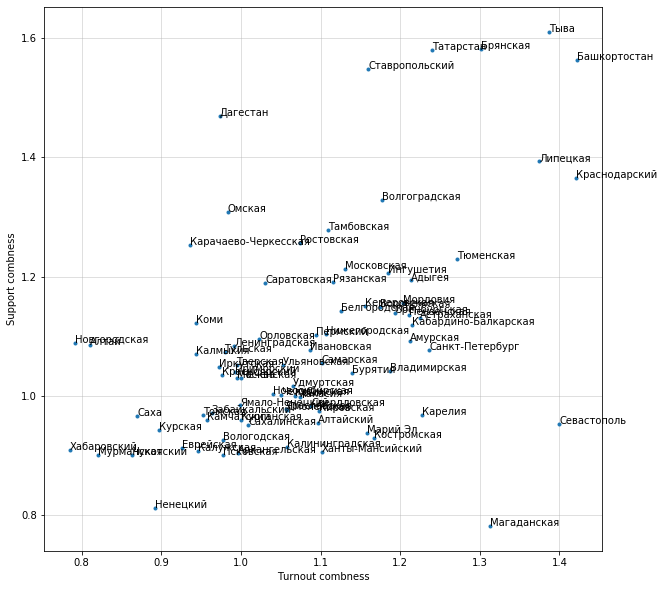

In [257]:
plt.figure(figsize=(10, 10))
plt.plot(ds.turn_comb, ds.supp_comb, '.');
plt.grid(alpha = 0.5)
for i in range(len(ds)):
    plt.text(ds.turn_comb.values[i], ds.supp_comb.values[i], ds.index.tolist()[i]);
plt.xlabel('Turnout combness');
plt.ylabel('Support combness');